In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
!pip install -q tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
df_clean=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/diploma/half_clean_data.csv', sep='\t')

In [45]:
df_clean=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/diploma/analys_clean_data.csv', sep='\t')

In [42]:
df_clean=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/diploma/clean_data.csv', sep='\t')

,Unnamed: 0,date,time,text_news,label
0,0,2022-02-22,13:50:00,dpr said ukrainian security force used grad ml...,False
1,4,2022-02-22,14:07:00,rely strength rule turn russian federation mil...,False
2,5,2022-02-22,14:08:00,parliament ukraine adopted statement calling r...,False
3,6,2022-02-22,14:08:00,russia recognized independence dpr lpr donetsk...,False
4,9,2022-02-22,14:31:00,hungary meeting committee permanent representa...,False
...,...,...,...,...,...
12576,14484,2023-04-24,08:03:00,meeting minister defense turkey russia syria i...,False
12577,14485,2023-04-24,11:46:00,kiev never enough people equipment professiona...,False
12578,14486,2023-04-24,11:52:00,ukrainian troop left couple brigade artemovsk ...,False
12579,14487,2023-04-24,12:47:00,today 330 kiev regime made attempt attack base...,False


In [ ]:
nan_values = df_clean['text_news'].isna()

In [ ]:
df_clean["label"].value_counts()

False    6630
True     5951
Name: label, dtype: int64

## Preprocessing

In [71]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [72]:
preprocess_url = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
encoder_url = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [73]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

## Training model (text)

In [74]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(df_clean['text_news'], df_clean['label'],test_size=0.2, random_state=7 )

In [75]:
x_train = np.array([np.array(val) for val in x_train])

In [76]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_news')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [77]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

In [78]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 10 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

In [79]:
model_history = model.fit(
    x_train, y_train,
    epochs=50,
    steps_per_epoch=20,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ])

Epoch 1/50
20/20 [==============================] - 45s 2s/step - loss: 0.8764 - accuracy: 0.5258 - precision: 0.4911 - recall: 0.4615 - lr: 0.0100
Epoch 2/50
20/20 [==============================] - 35s 2s/step - loss: 0.7046 - accuracy: 0.5750 - precision: 0.5377 - recall: 0.5000 - lr: 0.0100
Epoch 3/50
20/20 [==============================] - 35s 2s/step - loss: 0.6520 - accuracy: 0.6195 - precision: 0.6120 - recall: 0.5580 - lr: 0.0100
Epoch 4/50
20/20 [==============================] - 34s 2s/step - loss: 0.6699 - accuracy: 0.6023 - precision: 0.5831 - recall: 0.5431 - lr: 0.0100
Epoch 5/50
20/20 [==============================] - 34s 2s/step - loss: 0.6803 - accuracy: 0.6008 - precision: 0.5749 - recall: 0.4915 - lr: 0.0100
Epoch 6/50
20/20 [==============================] - 35s 2s/step - loss: 0.6336 - accuracy: 0.6453 - precision: 0.6383 - recall: 0.5617 - lr: 0.0100
Epoch 7/50
20/20 [==============================] - 35s 2s/step - loss: 0.6255 - accuracy: 0.6582 - precision: 0

In [87]:
model.save_weights("/content/drive/MyDrive/Colab_Notebooks/diploma/model/model_71.h5")

In [17]:
print('Using TensorFlow version', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Using TensorFlow version 2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [80]:
model_history.history

{'loss': [0.8763765096664429,
  0.7046226263046265,
  0.6519663333892822,
  0.6699249148368835,
  0.6802893280982971,
  0.633552610874176,
  0.6255258917808533,
  0.6270135641098022,
  0.6276392340660095,
  0.6218815445899963,
  0.6201109886169434,
  0.6176839470863342,
  0.6141728162765503,
  0.6218457221984863,
  0.6181851029396057,
  0.6073799729347229,
  0.6285702586174011,
  0.6118249893188477,
  0.601181149482727,
  0.6040407419204712,
  0.60617595911026,
  0.5927920341491699,
  0.6067535877227783,
  0.6129951477050781,
  0.5996306538581848,
  0.609907329082489,
  0.6054211854934692,
  0.6016963720321655,
  0.6028271317481995,
  0.5999236106872559,
  0.6044281721115112,
  0.5946773886680603,
  0.6001294255256653,
  0.6142556667327881,
  0.5941686034202576,
  0.6048278212547302,
  0.610613226890564,
  0.5948683023452759,
  0.5921801924705505,
  0.612442135810852,
  0.6049858331680298,
  0.5888403654098511,
  0.599853515625,
  0.5986852645874023,
  0.6074782609939575,
  0.606763660

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab_Notebooks/diploma/model/model_71.h5")

In [81]:
model.evaluate(x_test, y_test)

79/79 [==============================] - 29s 349ms/step - loss: 0.5830 - accuracy: 0.7171 - precision: 0.7432 - recall: 0.6414


[0.5830490589141846,
 0.7171235680580139,
 0.7431539297103882,
 0.6414017677307129]

In [82]:
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

79/79 [==============================] - 28s 340ms/step


In [83]:
y_pred = np.where(y_pred > 0.5, 1, 0)

Confusion matrix

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

#Build confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[1018,  272],
       [ 440,  787]])

Text(50.722222222222214, 0.5, 'Truth')

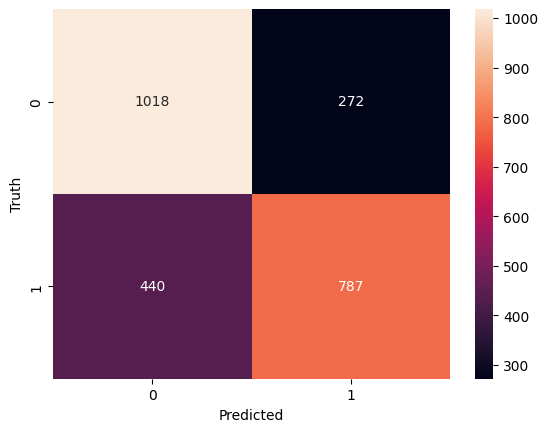

In [85]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.70      0.79      0.74      1290
        True       0.74      0.64      0.69      1227

    accuracy                           0.72      2517
   macro avg       0.72      0.72      0.71      2517
weighted avg       0.72      0.72      0.72      2517



Example

In [ ]:
reviews = [
    "TRUMP ARRIVES IN MOBILE, ALABAMA TO SAY THANKS", 
    "Trump says Russia probe will be fair, but timeline unclear: NYT",
    "Virginia officials postpone lottery drawing to decide tied statehouse election",
    "Trump on Twitter (Dec 26) - Hillary Clinton, Tax Cut Bill"]
model.predict(reviews)

1/1 [==============================] - 1s 846ms/step


array([[0.51965785],
       [0.23493822],
       [0.01219416],
       [0.7789744 ]], dtype=float32)